# Простейшая рекуррентная сеть
В этом ноутбуке мы пройдемся по основам работы с RNN. Сегодня займемся задачей генерации текста. 

In [300]:
import warnings
from typing import Iterable, Tuple
import torch
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
from IPython.display import clear_output
from torch.utils.data import Dataset, DataLoader
from collections import Counter
from torch import nn
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
from torch.distributions.categorical import Categorical
import torch.nn.functional as F

warnings.filterwarnings("ignore")

В качестве обучающего датасета возьмем набор из 120 тысяч анекдотов на русском языке. 
[Ссылка на данные](https://archive.org/download/120_tysyach_anekdotov) и [пост на хабре про тематическое моделирование](https://habr.com/ru/companies/otus/articles/723306/)

In [301]:
with open(r"../../data/anek_djvu.txt", "r", encoding="utf-8") as f:
    text = f.read()
    f.close()
text[118:500]

'|startoftext|>Это ГООООЛ\n\n<|startoftext|>Это ГООООЙЙЙДАААА!\n\n<|startoftext|>Друзья мои, чтобы соответствовать вам, я готов сделать над собой усилие и стать лучше. Но тогда и вы станьте немного хуже!\n\n<|startoftext|>- Люся, ты все еще хранишь мой подарок?- Да.- Я думал, ты выкинула все, что со мной связано.- Плюшевый мишка не виноват, что ты ебл@н...\n\n<|startoftext|>- А вот скажи '

Мы не хотим моделировать все подряд, поэтому разобьем датасет на отдельные анекдоты.  

In [302]:
def cut_data(text):
    return text.replace("\n\n", "").split("<|startoftext|>")[1:]

In [303]:
cut_text = cut_data(text)

In [304]:
cut_text[1:6]

['Это ГООООЛ',
 'Это ГООООЙЙЙДАААА!',
 'Друзья мои, чтобы соответствовать вам, я готов сделать над собой усилие и стать лучше. Но тогда и вы станьте немного хуже!',
 '- Люся, ты все еще хранишь мой подарок?- Да.- Я думал, ты выкинула все, что со мной связано.- Плюшевый мишка не виноват, что ты ебл@н...',
 '- А вот скажи честно, ты во сне храпишь?- Понятие не имею, вроде, нет. От собственного храпа по крайней мере еще ни разу не просыпался.- Ну, так у жены спроси.- А жена и подавно не знает. У нее странная привычка после замужества возникла: как спать ложится - беруши вставляет.']

Сделаем для начала самую простую модель с токенами на уровне символов. Это значит, что каждому символу в тексте ставится в соответствие некоторое число. Некоторые способы токенизации используют части слов или, наоборот, части бинарного представления текста.

In [305]:
unique_chars = tuple(set(text))
int2char = dict(enumerate(tuple(set(text))))
char2int = {ch: ii for ii, ch in int2char.items()}


Напишем функции для энкодинга и декодинга нашего текста. Они будут преобразовывать список символов в список чисел и обратно.

In [306]:
def encode(sentence, vocab):
    return [vocab[x] for x in sentence] # List of ints 

def decode(tokens, vocab):
    return [vocab[x] for x in tokens]# list of strings

In [307]:
# Проверьте, что энеодинг и декодинг работают
t = encode(cut_text[0], char2int)
print(encode(cut_text[0], char2int))
print(decode(t, int2char))

[55, 84, 121, 83, 178, 84, 191, 198, 205, 91, 42, 12, 152, 121, 150, 191, 72, 12, 84, 191, 117, 121, 84, 134, 84, 191, 0, 175, 119, 13, 34, 84, 0, 191, 34, 205, 47, 152, 13, 205, 42, 12, 117, 1, 191, 117, 205, 91, 152, 91, 152, 191, 199, 42, 34, 12, 13, 205, 121, 83, 34, 76, 91, 152, 191, 178, 121, 205, 134, 152, 88, 205, 91, 152, 105, 191, 25, 205, 178, 191, 134, 117, 42, 191, 175, 13, 84, 126, 180, 91, 205, 34, 84, 150, 191, 47, 121, 152, 34, 35]
['Т', 'о', 'л', 'ь', 'к', 'о', ' ', 'з', 'а', 'м', 'е', 'т', 'и', 'л', ',', ' ', 'ч', 'т', 'о', ' ', 'с', 'л', 'о', 'в', 'о', ' ', '"', 'п', '@', 'р', 'н', 'о', '"', ' ', 'н', 'а', 'б', 'и', 'р', 'а', 'е', 'т', 'с', 'я', ' ', 'с', 'а', 'м', 'и', 'м', 'и', ' ', 'ц', 'е', 'н', 'т', 'р', 'а', 'л', 'ь', 'н', 'ы', 'м', 'и', ' ', 'к', 'л', 'а', 'в', 'и', 'ш', 'а', 'м', 'и', '.', ' ', 'К', 'а', 'к', ' ', 'в', 'с', 'е', ' ', 'п', 'р', 'о', 'д', 'у', 'м', 'а', 'н', 'о', ',', ' ', 'б', 'л', 'и', 'н', '!']


Просто представления символов в виде числа не подходят для обучения моделей. На выходе должны быть вероятности всех возможных токенов из словаря. Поэтому модели удобно учить с помощью энтропии. К тому же, токены часто преобразуют из исходного представления в эмбеддинги, которые также позволяют получить более удобное представление в высокоразмерном пространстве. 

В итоге векторы в модели выглядят следующим образом:
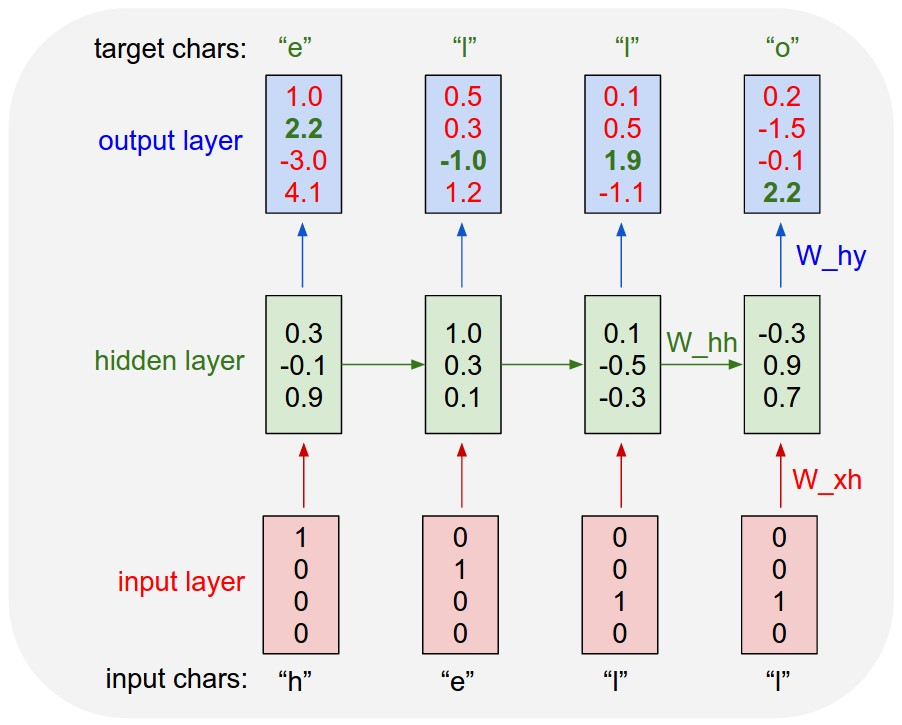

Задание: реализуйте метод, который преобразует батч в бинарное представление.

In [308]:
def one_hot_encode(int_words: torch.Tensor, vocab_size: int) -> torch.Tensor:
    """Encodes batch of sentences into binary values"""
    words_one_hot = torch.zeros(

        (int_words.numel(), vocab_size), dtype=int_words.dtype, device=int_words.device
        # init one hot tensor. 
    )
    words_one_hot[torch.arange(words_one_hot.shape[0]), int_words.flatten()] = 1
    words_one_hot = words_one_hot.reshape((*int_words.shape, vocab_size))
    # your code: make from int one hot vector for each element of input tensor. Size bxseq_len -> b x seq_len x vocab_size
    return words_one_hot

Проверьте ваш код.

In [309]:
test_seq = torch.tensor([[2, 6, 4, 1], [0, 3, 2, 4]])
test_one_hot = one_hot_encode(test_seq, 8)

print(test_one_hot)

tensor([[[0, 0, 1, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 1, 0],
         [0, 0, 0, 0, 1, 0, 0, 0],
         [0, 1, 0, 0, 0, 0, 0, 0]],

        [[1, 0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 1, 0, 0, 0, 0],
         [0, 0, 1, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 1, 0, 0, 0]]])


Однако, наши последовательности на самом деле разной длины. Как же объединить их в батч?

Реализуем два необходимых класса: 
- токенайзер, который будет брать текст, кодировать и декодировать символы. Еще одно, что будет реализовано там - добавлено несколько специальных символов (паддинг, конец последовательности, начало последовательности).
- Датасет, который будет брать набор шуток, используя токенайзер, строить эмбеддинги и дополнять последовательность до максимальной длины.

In [310]:
class Tokenizer:
    def __init__(self, cut_text, max_len: int = 128):
        self.text = cut_text
        self.max_len = max_len
        self.specials = ['<pad>', '<bos>', '<eos>']
        unique_chars = tuple(set(cut_text))
        self.int2char = dict(enumerate(tuple(set(cut_text))))
        self.char2int = {ch: ii for ii, ch in self.int2char.items()}
        self._add_special("<pad>")
        self._add_special('<bos>')
        self._add_special('<eos>')
    
    def _add_special(self, symbol) -> None:
        # add special characters to yuor dicts
        sym_num = len(self.char2int)
        self.char2int[symbol] = sym_num
        self.int2char[sym_num] = symbol

    @property
    def vocab_size(self):
        return len(self.int2char) # your code
        
    def decode_symbol(self, el):
        return self.int2char[el]
        
    def encode_symbol(self, el):
        return self.char2int[el]
        
    def str_to_idx(self, chars):
        return [self.char2int[sym] for sym in chars] # str -> list[int]

    def idx_to_str(self, idx):
        return [self.int2char[toc] for toc in idx] # list[int] -> list[str]

    def encode(self, chars, eos=True):
        if eos:
            chars = ['<bos>'] + list(chars) + ['<eos>']
        else:
            chars = ['<bos>'] + list(chars)
        return self.str_to_idx(chars)

    def decode(self, idx):
        chars = self.idx_to_str(idx)
        return "".join(chars) # make string from list

In [315]:
class JokesDataset(Dataset):
    def __init__(self, tokenizer, cut_text, max_len: int = 512):
        self.max_len = max_len
        self.tokenizer = tokenizer
        self.cut_text = cut_text
        self.pad_index = self.tokenizer.encode_symbol("<pad>")

    def __len__(self):
        return len(self.cut_text)
        
    def __getitem__(self, item):
        # pad your sequence and make a final sample. You can skip padding and pad sequences with torch special method.
        encoded = self.tokenizer.encode(self.cut_text[item])[:self.max_len]
        padded = torch.full((self.max_len, ), self.pad_index, dtype=torch.long)
        padded[:len(encoded)] = torch.tensor(encoded)
        return padded, len(encoded)

# Optionally add new methods to your dataset class

In [316]:
tokenizer = Tokenizer(text, 64)
dataset = JokesDataset(tokenizer, cut_text, 64)
dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

In [317]:
print(t)
print(tokenizer.decode(t))

[55, 84, 121, 83, 178, 84, 191, 198, 205, 91, 42, 12, 152, 121, 150, 191, 72, 12, 84, 191, 117, 121, 84, 134, 84, 191, 0, 175, 119, 13, 34, 84, 0, 191, 34, 205, 47, 152, 13, 205, 42, 12, 117, 1, 191, 117, 205, 91, 152, 91, 152, 191, 199, 42, 34, 12, 13, 205, 121, 83, 34, 76, 91, 152, 191, 178, 121, 205, 134, 152, 88, 205, 91, 152, 105, 191, 25, 205, 178, 191, 134, 117, 42, 191, 175, 13, 84, 126, 180, 91, 205, 34, 84, 150, 191, 47, 121, 152, 34, 35]
Только заметил, что слово "п@рно" набирается самими центральными клавишами. Как все продумано, блин!


Вопрос: А как бы мы должны были разделять данные на последовательности и батчи в случае, если бы использовался сплошной текст?

In [318]:
# Задание: проверьте свой датасет
for i in dataloader:
    print(i)
    break


[tensor([[215,  26, 205,  ..., 205,  13,  47],
        [215,  26, 205,  ...,  34,  84, 139],
        [215,  74, 126,  ..., 205,   1, 191],
        ...,
        [215,  79,  84,  ...,  84,  47,  34],
        [215,  36, 117,  ..., 205, 178, 191],
        [215,  79,  13,  ...,  13, 205, 117]]), tensor([64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64,
        49, 64, 64, 64, 64, 64, 64, 64, 64, 63, 47, 64, 64, 64, 64, 64, 64, 64,
        64, 64, 64, 64, 50, 64, 54, 64, 64, 64, 64, 64, 64, 61, 64, 47, 64, 64,
        64, 64, 64, 64, 64, 64, 64, 64, 64, 64])]


Теперь реализуем нашу модель. 
Необходимо следующее:
 - Используя токенайзер, задать размер словаря
 - Задать слой RNN с помощью torch.RNN. Доп.задание: создайте модель, используя слой LSTM.
 - Задать полносвязный слой с набором параметров: размерность ввода — n_hidden; размерность выхода — размер словаря. Этот слой преобразует состояние модели в логиты токенов.
 - Определить шаг forward, который будет использоваться при обучении
 - Определить метод init_hidden, который будет задавать начальное внутреннее состояние. Инициализировать будем нулями.
 - Определить метод inference, в котором будет происходить генерация последовательности из префикса. Здесь мы уже не используем явные логиты, а семплируем токены на их основе.


Зададим параметры для обучения. Можете варьировать их, чтобы вам хватило ресурсов.

In [ ]:
import torch
import torch.nn as nn

class CharRNN2(nn.Module):
    def __init__(self, tokenizer, hidden_dim: int = 256, num_layers: int = 2, drop_prob: float = 0.5, max_len: int = 32,) -> None:
        super().__init__()
        self.n_hidden = hidden_dim
        self.n_layers = num_layers
        self.drop_prob = drop_prob
        self.max_len = max_len
        self.tokenizer = tokenizer
        self.vocab_size = tokenizer.vocab_size
        self.rnn = nn.LSTM(
            input_size=self.vocab_size,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            dropout=drop_prob,
            batch_first=True
        )
        self.dropout = nn.Dropout(drop_prob)
        self.fc = nn.Linear(hidden_dim, self.vocab_size)

    def forward(self, x: torch.Tensor, lengths: torch.Tensor):
        lengths, sort_idx = lengths.sort(0, descending=True)
        x = x[sort_idx]
        one_hot = torch.nn.functional.one_hot(x, num_classes=self.vocab_size).float()
        packed_embeds = pack_padded_sequence(one_hot, lengths, batch_first=True, enforce_sorted=True)
        outputs, hidden = self.rnn(packed_embeds)
        out, lengths = pad_packed_sequence(outputs, batch_first=True)
        out = self.dropout(out)
        out = self.fc(out)
        _, unsort_idx = sort_idx.sort(0)
        out = out[unsort_idx]
        lengths = lengths[unsort_idx]

        return out, hidden

    def inference(self, prefix='<bos>'):
        tokens = torch.tensor([self.tokenizer.encode_symbol(prefix)]).unsqueeze(0)
        h = None
        while tokens.shape[1] < self.max_len:
            last_token = tokens[:, -1]
            one_hot = torch.nn.functional.one_hot(last_token, num_classes=self.vocab_size).float()
            one_hot = one_hot.unsqueeze(1)  
            out, h = self.rnn(one_hot, h)
            logits = self.fc(out.squeeze(1))
            probs = torch.softmax(logits, dim=-1)
            new_token = torch.multinomial(probs, num_samples=1)
            tokens = torch.cat([tokens, new_token], dim=1)
            if new_token.item() == self.tokenizer.encode_symbol('<eos>'):
                break
        return self.tokenizer.decode(tokens.squeeze().tolist())

In [320]:
batch_size = 4
seq_length = 128
n_hidden = 32
n_layers = 3
drop_prob = 0.1
lr = 0.1

Напишите функцию для одного тренировочного шага. В этом ноутбуке сам процесс обучения модели достаточно тривиален, поэтому мы не будем использовать сложные функции для обучающего цикла. Вы же, однако, можете дописать их.

In [321]:
def training_step(
    model,
    train_batch: Tuple[torch.Tensor, torch.Tensor],
    vocab_size: int,
    criterion: nn.Module,
    optimizer,
    device="cpu"
) -> torch.Tensor:
    inputs, lengths = train_batch
    optimizer.zero_grad()
    batch_size, seq_len = inputs.shape
    targets = inputs[:, 1:]
    outputs, _ = model(inputs[:, :-1], lengths-1)
    tar = []
    for i, item in enumerate(lengths):
        tar.append(targets[i][:max(lengths)-1])
    targets = torch.stack(tar)
    targets = targets.reshape(len(inputs), -1)
    logits = outputs.view(-1, vocab_size) 
    targets = targets.view(-1)
    loss = criterion(logits, targets)
    loss.backward()
    optimizer.step()
    return loss.item()

Инициализируйте модель, функцию потерь и оптимизатор.

In [322]:
model = CharRNN2(tokenizer, n_hidden, n_layers, drop_prob, max_len=256)
hidden = None
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-2)


Проверьте необученную модель: она должна выдавать бессмысленные последовательности

In [323]:
# Your code: test inference
print(model.inference())

<bos>﻿/Y命Ь<eos>


In [324]:
tokenizer.decode([215, 179, 170])

'<bos>代^'

In [325]:
def plot_losses(losses):
    clear_output()
    plt.plot(range(1, len(losses) + 1), losses)
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.show()

Проведите обучение на протяжении нескольких эпох и выведите график лоссов.

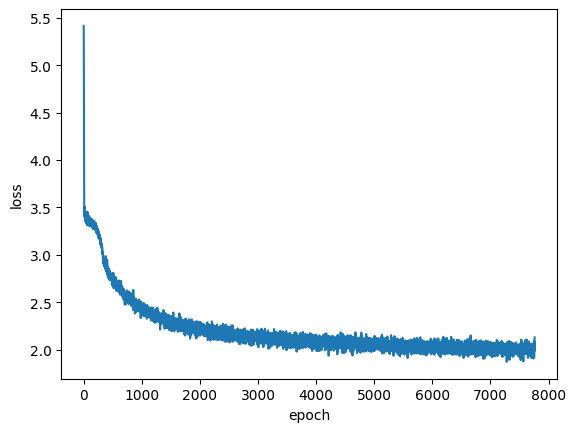

In [326]:
losses = []
num_epochs = 4

for epoch in range(1, num_epochs + 1):
    # your code: run model traininig for n epochs
    for item in dataloader:
        loss = training_step(model, item, tokenizer.vocab_size, criterion, optimizer)
        losses.append(loss)
    plot_losses(losses)
    torch.save(model.state_dict(), f"rnn.pt")

In [327]:
[model.inference(prefix="<bos>") for _ in range(5)]

['<bos>К падоново конце тельимнуя дол молосик в вверго дюпей это саков копонатано исваш на всем так почему у тлох в к рассколи полевность друшят р ресчиска и ничем оне за истат всей не считымен ет чя зальчивие поуй, что сожласка яч как... грунишку одном ворое пи',
 '<bos>По чекаченьтчим" Кинляни?- Аткука.Прикуочнуя... Совита. Это ты впрогасниксть! Я дискабьхека дела Фортамкое подсат ссоложят "в стомавнуй, что собор свКжимени?- Пел гасн крапит" навечфивают напатик, говорин, а ты анльзик оне жисание:<eos>',
 '<bos>- Ста Нолуть я касы. Оне влебеле, страдился черестра! Омноарвасничило с поейтны много кехиле, смиця - большей сешьцо, я мажном бову рукло" зромкиты езвствост.<eos>',
 '<bos>- Никогда не солден темная молже где отнонса ты самами избидить.<eos>',
 '<bos>В стимийства которае Непредо допейгаека, узнаешь моягает вталял предокир, качит жело лиле колнимость, що порепоцевский очней, костаты.- Я мемшинствей я повнот Притоленкой осло0лится взжанят конаца водке давков!<eos>']

Теперь попробуем написать свой собственный RNN. Это будет довольно простая модель с одним слоем.


In [ ]:
# YOUR CODE: custom model nn.Module, changed CharRNN, etc

### Task 1 (hw):

In [281]:
import re
import string

class WordTokenizer:
    def __init__(self, special_tokens: list[str] = None):
        if special_tokens is None:
            special_tokens = ['<bos>', '<eos>', '<?>', '<pad>']
        self.token_to_index = {}
        self.index_to_token = {}
        for token in special_tokens:
            self.add_token(token)
    
    def add_token(self, token: str) -> int:
        index = len(self.token_to_index)
        if token not in self.token_to_index and index < 8001:
            self.token_to_index[token] = index
            self.index_to_token[index] = token
        return None
    
    def encode(self, text: str) -> list[int]:
        tokens = self._tokenize(text)
        tokens = ['<bos>'] + tokens + ['<eos>']
        encoded = []
        for token in tokens:
            if token not in self.token_to_index:
                token = '<?>'
            encoded.append(self.token_to_index[token])
        return encoded
    
    def decode(self, indices: list[int]) -> str:
        tokens = []
        for idx in indices:
            tokens.append(self.index_to_token[idx])
        return ' '.join(tokens)
    
    def _tokenize(self, text: str) -> list[str]:
        tokens = text.split()
        return tokens
    
    def preprocess(
        self,
        text: str,
        lowercase: bool = True,
        remove_punctuation: bool = True,
        remove_numbers: bool = False,
        remove_extra_whitespace: bool = True,
    ) -> str:
        # Convert to lowercase
        if lowercase:
            text = text.lower()
        # Remove punctuation
        if remove_punctuation:
            text = text.translate(str.maketrans('', '', string.punctuation))
        # Remove numbers 
        if remove_numbers:
            text = re.sub(r'\d+', '', text)
        # Remove extra whitespace
        if remove_extra_whitespace:
            text = re.sub(r'\s+', ' ', text).strip()
        return text
    
    def encode_symbol(self, sym):
        return self.token_to_index[sym]
    
    @property
    def vocab_size(self) -> int:
        return len(self.token_to_index)


In [282]:
tokenizer2 = WordTokenizer()

text2 = []
for i in cut_text:
    text2.append(tokenizer2.preprocess(i))


In [283]:
for i in text2:
    st = tokenizer2._tokenize(i)
    for o in st:
        i = tokenizer2.add_token(o)


In [284]:
t = tokenizer2.encode(text2[0])
print(t)
t = tokenizer2.decode(t)
print(t)
print(tokenizer2._tokenize(text2[0]))

[0, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 1]
<bos> только заметил что слово прно набирается самими центральными клавишами как все продумано блин <eos>
['только', 'заметил', 'что', 'слово', 'прно', 'набирается', 'самими', 'центральными', 'клавишами', 'как', 'все', 'продумано', 'блин']


In [285]:
class JokesDataset2(Dataset):
    def __init__(self, tokenizer, cut_text, max_len: int = 64):
        self.max_len = max_len
        self.tokenizer = tokenizer
        self.cut_text = cut_text
        self.pad_index = tokenizer.encode_symbol('<pad>')

    def __len__(self):
        return len(self.cut_text)
        
    def __getitem__(self, item):
        encoded = self.tokenizer.encode(self.cut_text[item])[:self.max_len]
        padded = torch.full((self.max_len, ), self.pad_index, dtype=torch.long)
        padded[:len(encoded)] = torch.tensor(encoded)
        return padded, len(encoded)

In [286]:
dataset2 = JokesDataset2(tokenizer2, text2, 64)
dataloader2 = DataLoader(dataset2, batch_size=64, shuffle=True)

In [287]:
for i in dataloader2:
    print(i)
    break


[tensor([[   0,    2,    2,  ...,    3,    3,    3],
        [   0, 1360,    2,  ...,    3,    3,    3],
        [   0,  210, 2754,  ...,    3,    3,    3],
        ...,
        [   0, 7024, 1148,  ...,    3,    3,    3],
        [   0,  119,    2,  ...,    3,    3,    3],
        [   0,    2,    2,  ...,    3,    3,    3]]), tensor([19, 29, 14, 21,  9, 22,  9, 10, 18, 26, 25, 16, 18, 20, 20, 14, 27, 21,
        25,  9, 21, 25, 22, 12, 25,  8,  7, 30, 14, 43, 16,  8, 18, 24, 12,  9,
         7, 22, 23, 16, 22,  8, 14, 26, 11, 12, 20, 42, 16, 11, 20, 12, 11, 19,
        26, 24, 19, 12, 28, 38, 18, 17, 17, 25])]


In [288]:
model2 = CharRNN2(tokenizer2, 32, 3, drop_prob, max_len=32)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)


In [289]:
model2.inference()

'<bos> задержан приснился разгоняюсь собрал сообщить доктор слов становиться выходят конторе както довольствоваться прятался людьми 42 козни мата иллюстрация организованно вовочка пятьдесят поехать внезапно мягким выгуливая сисадмина озеро украина собаками крестьянский лукашенко'

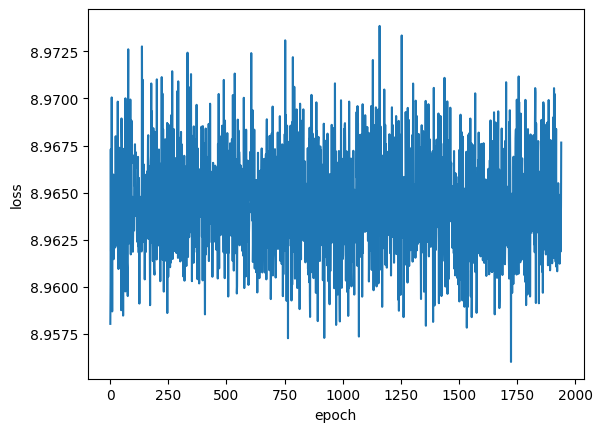

KeyboardInterrupt: 

In [290]:
losses = []
num_epochs = 4

for epoch in range(1, num_epochs + 1):
    # your code: run model traininig for n epochs
    for item in dataloader2:
        loss = training_step(model2, item, tokenizer2.vocab_size, criterion, optimizer)
        losses.append(loss)
    plot_losses(losses)
    torch.save(model.state_dict(), f"rnn_words.pt")

In [299]:
model2.inference()

'<bos> осознавать состав оказавшись милостыню пейс дураком копыто перестанем 7 громко двум геленджик ремонтный стираю возможно старого вернулась 300 увлажнители садистской правой сексе повязать клапан главнокомандующий нагадить обж месть ныряет аптечке вид'